# Merge all the diffrent data to one big data frame

In [7]:
# Data handling and plotting
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser  # More robust date parsing

# MongoDB
from pymongo import MongoClient
from bson import ObjectId


import numpy as np
import imblearn
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import specificity_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

import mord


In [8]:
heart_rate = pd.read_csv("csv/Heart_Rate.csv")
print(heart_rate.head())

hrv = pd.read_csv("csv/HRV.csv")
print(hrv.head())

mood = pd.read_csv("csv/Mood.csv")
print(mood.head())

sleep = pd.read_csv("csv/sleep.csv")
print(sleep.head())

steps = pd.read_csv("csv/steps.csv")
print(steps.head())

resting_heart_rate = pd.read_csv("csv/resting_heart_rate.csv")
print(resting_heart_rate.head())

         date  heartrate
0  2021-10-23  84.603987
1  2021-10-24  78.530959
2  2021-10-25  74.846546
3  2021-10-26  79.038225
4  2021-10-27  78.103234
         date   RMSSD  Entropy
0  2021-10-24  28.400    2.286
1  2021-10-25  23.568    2.109
2  2021-10-26  17.974    2.278
3  2021-10-27  19.410    2.613
4  2021-10-28  19.028    2.443
         date  mood_score
0  2021-11-15         1.0
1  2021-11-16        -3.0
2  2021-11-17         0.0
3  2021-11-18        -2.0
4  2021-11-19        -2.0
         date  total_sleep     light      deep       rem  weekly_avg
0  2021-10-24     8.750000  5.666667  1.066667  2.016667         NaN
1  2021-10-25     5.683333  3.600000  0.650000  1.433333         NaN
2  2021-10-26     6.933333  3.700000  1.016667  2.216667         NaN
3  2021-10-27     5.033333  2.783333  0.833333  1.416667         NaN
4  2021-10-28     8.416667  4.933333  1.333333  2.150000         NaN
         date  steps
0  2021-10-23   6873
1  2021-10-24   5317
2  2021-10-25   6640
3  2021-10

In [9]:
merged = heart_rate.merge(hrv,on='date',how='outer').merge(mood,on='date',how='outer').merge(sleep,on='date',how='outer').merge(steps,on='date',how='outer').merge(resting_heart_rate,on='date',how='outer')

In [10]:
merged = merged.dropna(thresh=7) #Alle records met te veel missende features droppen
merged = merged[~merged['mood_score'].isna()] #Enkel de records waar een moodscore voor is gebruiken
merged = merged.drop(columns="date") #Date bevat geen nuttige gegevens met wat we willen onderzoeken
merged.isna().describe()

,heartrate,RMSSD,Entropy,mood_score,total_sleep,light,deep,rem,weekly_avg,steps,restingHeartRate,errorRHR
count,66,66,66,66,66,66,66,66,66,66,66,66
unique,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,66,66,66,66,66,66,66,66,66,66,66,66



## Model training

In [11]:
def train_RandomForestModel(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    spec = specificity_score(y_true, y_pred, average='weighted') 
    return {'accuracy': acc, 'precision': prec, 'recall': recall, 'specificity': spec}

def train_OrdinalLogisticRegrModel(X_train, y_train):
    model = mord.LogisticIT()
    model.fit(X_train, y_train)
    return model

In [12]:
X = merged.drop(columns="mood_score")
y = merged['mood_score'].astype(int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rfModel = train_RandomForestModel(X_train, y_train)
y_pred = rfModel.predict(X_test)
metricsRf = evaluate_model(y_test, y_pred)

In [14]:
for x, y in metricsRf.items():
  print(x, y)

accuracy 0.2
precision 0.17083333333333334
recall 0.2
specificity 0.8208462332301341


Text(77.92222222222227, 0.5, 'Actual')

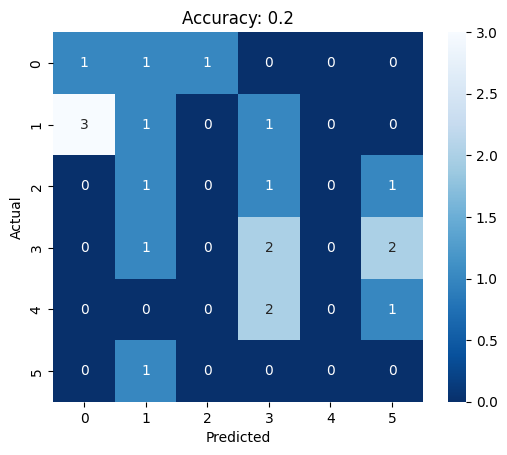

In [15]:
cm = confusion_matrix(y_test,y_pred)
plt.figure()
sns.heatmap(cm, annot=True, square = True, cmap = 'Blues_r')
plt.title(f'Accuracy: {metricsRf['accuracy']}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(77.92222222222227, 0.5, 'Actual')

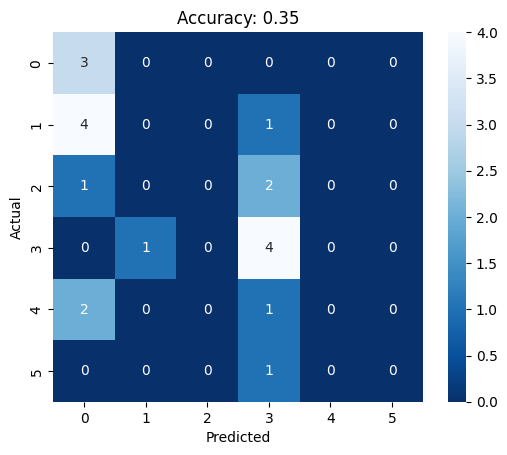

In [16]:
olrModel = train_OrdinalLogisticRegrModel(X_train, y_train)
y_pred = olrModel.predict(X_test)
metricsOlr = evaluate_model(y_test, y_pred)

cm = confusion_matrix(y_test,y_pred)
plt.figure()
sns.heatmap(cm, annot=True, square = True, cmap = 'Blues_r')
plt.title(f'Accuracy: {metricsOlr['accuracy']}')
plt.xlabel('Predicted')
plt.ylabel('Actual')